### EDA and Topic modeling of recipe corpus

- We can do some EDA on the scrapped and preprocessed data from previous step
- Perform topic modeling on the recipe corpus and extract topics 
- Group the recipes with main category and sub category
- Pickle the dataframe that we might need for further analysis

In [1]:

import pickle
import os
from itertools import chain
import pandas as pd
import io

import urllib.request
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook
tqdm.pandas()

import time
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
%matplotlib inline

from recipeScript import *
from miscScript import *

c:\users\heman\.conda\envs\tensor\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
c:\users\heman\.conda\envs\tensor\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\heman\Documents\DS\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import dataframe
with open('df_epi_cleaner.pkl','rb') as fin:
    df = pickle.load(fin)

In [3]:
#turn titles into lowercase

df['title'] = df['title'].apply(lambda word: word.lower())

In [4]:
# Checkout different cuisines of the world 
# printNum() is imported from recipeScript.py
dump = printNum(df,['korean','chinese','japanese','italian','french','mexican','indian','thai',
          'cajun','vietnamese','american','german','spanish','mediterranian','polish',
         'greek','jamaican','african','ethiopian','turkish','indonesian'],'cuisine')

### Let's see the distribution of cuisines

In [5]:
dump.reset_index(drop=True).sort_values(by='number',ascending=False)

,cuisine,number
5,french,157
18,thai,121
10,italian,113
15,mexican,113
3,chinese,79
7,greek,76
8,indian,71
17,spanish,45
20,vietnamese,42
12,japanese,33


In [6]:
# Check out different types of dishes 
printNum(df,['salad','barbecue','roast','pizza','soup',
              'curry','pasta','antipasti','bbq',
              'stew','cake','cookie','wrap','sandwich',
          'chicken'],
        dish_type='type').reset_index(drop=True).sort_values(by='number', ascending=False)

,type,number
10,salad,2658
4,chicken,2000
9,roast,1900
3,cake,1873
12,soup,1137
5,cookie,545
11,sandwich,443
7,pasta,402
13,stew,273
8,pizza,252


### Most common words in recipe titles

In [7]:
# Create words out of title
df['words'] = df['title'].progress_apply(lambda sent: [word for word in sent.split()])

100%|████████████████████████████████████████████████████████████████████████| 35965/35965 [00:00<00:00, 114896.20it/s]


In [8]:

# Create column with processed-Text
df['words'] = df['words'].progress_apply(preprocessText)

100%|█████████████████████████████████████████████████████████████████████████| 35965/35965 [00:01<00:00, 25316.08it/s]


In [9]:
df['words'].values  # values will always return an array we will flatten this array using itertools

array([list(['okonomiyaki', 'like', 'pancakes', 'bonito', 'flakes']),
       list(['paneer', 'butter', 'masala']),
       list(['pesto', 'pasta', 'frittata']), ...,
       list(['scallop', 'bacon', 'chowder']),
       list(['cranberry', 'walnut', 'tart']),
       list(['grilled', 'asian', 'style', 'salmon', 'cabbage', 'mint', 'slaw'])],
      dtype=object)

In [10]:
# Combine all words in titles into a single bag-of-words
# using itertools here ---- chain.from_iterable(['ABC', 'DEF']) --> A B C D E F
bag_of_texts = list(chain.from_iterable(df['words'].values))

In [11]:
bag_of_texts

['okonomiyaki',
 'like',
 'pancakes',
 'bonito',
 'flakes',
 'paneer',
 'butter',
 'masala',
 'pesto',
 'pasta',
 'frittata',
 'salmon',
 'confit',
 'lime',
 'juniper',
 'fennel',
 'coconut',
 'braised',
 'chickpeas',
 'sweet',
 'potatoes',
 'greens',
 'crispy',
 'sheet',
 'pan',
 'broccoli',
 'prawn',
 'moilee',
 'spinach',
 'feta',
 'cooked',
 'like',
 'saag',
 'paneer',
 'cardamom',
 'pistachio',
 'bûche',
 'de',
 'noël',
 'tonnato',
 'eggs',
 'chickpea',
 'mushroom',
 'burgers',
 'kimchi',
 'soup',
 'tofu',
 'clams',
 'roasted',
 'cabbage',
 'steaks',
 'crispy',
 'chickpeas',
 'herby',
 'croutons',
 'creamy',
 'squash',
 'risotto',
 'toasted',
 'pepitas',
 'winter',
 'salad',
 'hummus',
 'bowls',
 'ponche',
 'crème',
 'seedy',
 'power',
 'sprinkle',
 'salad',
 'pasta',
 'martini',
 'rocks',
 'oystertini',
 'sakura',
 'martini',
 'allies',
 'cocktail',
 'puritan',
 'cocktail',
 'tuxedo',
 'obituary',
 'cocktail',
 'classic',
 'dry',
 'martini',
 'chard',
 'wrapped',
 'fish',
 'lemon

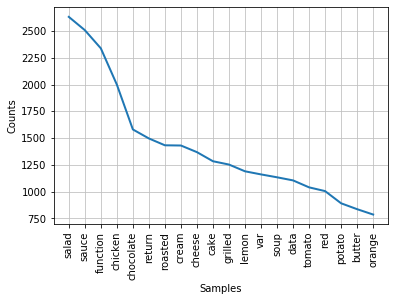

In [12]:
# Plot most frequently-used words
freq_words = nltk.FreqDist(bag_of_texts)
freq_words.plot(20, cumulative=False)

### tfidf vectorizer on tokenized data
It's tricky to do it. Usually we just feed in the corpus of data into vectorizer and it will take care of tokenizing and carry on with vectorizing(bundled) but now that we have tokenized data how to use tfidf vectorizer? 

[There is a hack](http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/)

In [13]:
# Use this if we are using TfIdf on tokenized 
def dummy_func(doc):
    return doc

# df_title['texts'] is the already tokenized document
tokenized_docs = df['words'].tolist()

# vectorize documents with TF-IDF
tfidfVectorizer = TfidfVectorizer(analyzer='word',
                                  tokenizer=dummy_func,
                                  preprocessor=dummy_func,
                                  token_pattern=None,
                                  ngram_range=(1,1))
# Fit transform
tfidfVectorizer.fit(tokenized_docs)
dtm = tfidfVectorizer.transform(tokenized_docs)

In [14]:
# view the dtm in a dataframe
df_dtm = pd.DataFrame(dtm.toarray(),
             index= df.title,
            columns = tfidfVectorizer.get_feature_names())

In [15]:
df_dtm.head()

,aamconde,ab,abbc,abbey,abcdefghijklmnopqrst,abesha,abinsthe,abiquiu,abp,abrupt,...,zucchine,zucchini,zuder,zuni,zuppa,zwetschgenkuchen,ácida,árbol,épices,étouffée
title,,,,,,,,,,,,,,,,,,,,,
okonomiyaki (“as you like it”) pancakes with bonito flakes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
paneer butter masala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pesto pasta frittata,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
salmon confit with lime juniper and fennel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coconut-braised chickpeas with sweet potatoes and greens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Topic modeling with NMF

In [16]:
# Build an NMF with 20 topics

nmf = NMF(20)
nmf.fit(dtm)
nmf_topics = nmf.transform(dtm)

In [17]:

# Check dataframe of words in dtm   
df_topics = pd.DataFrame(nmf.components_.round(3),
                         index=[str(k+1) for k in range(20)],
                         columns= tfidfVectorizer.get_feature_names())
df_topics

,aamconde,ab,abbc,abbey,abcdefghijklmnopqrst,abesha,abinsthe,abiquiu,abp,abrupt,...,zucchine,zucchini,zuder,zuni,zuppa,zwetschgenkuchen,ácida,árbol,épices,étouffée
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.000,0.000,0.006,0.000,0.0,0.000,0.000,0.0,0.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.004,0.000,0.000,0.000,0.0,0.002,0.000,0.0,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.012,0.000,0.002,0.000,0.0,0.000,0.000,0.0,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,...,0.0,0.000,0.000,0.003,0.000,0.0,0.000,0.000,0.0,0.000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.035,0.000,0.000,0.001,0.0,0.002,0.002,0.0,0.000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.019,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.091,0.000,0.000,0.003,0.0,0.000,0.000,0.0,0.000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.021,0.005,0.000,0.000,0.0,0.000,0.000,0.0,0.003
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.072,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.029,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000


In [18]:

# Create a dataframe of Observations vs TOPICS

df_obs_topics = pd.DataFrame(nmf_topics.round(3),
                index= df.title,
                columns = [str(k+1) for k in range(20)])
df_obs_topics.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
title,,,,,,,,,,,,,,,,,,,,
okonomiyaki (“as you like it”) pancakes with bonito flakes,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.003,0.0,0.000,0.001,0.0,0.000,0.001,0.000,0.001,0.001,0.000
paneer butter masala,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.099,0.000
pesto pasta frittata,0.001,0.0,0.001,0.001,0.002,0.0,0.003,0.007,0.002,0.001,0.0,0.001,0.000,0.0,0.008,0.000,0.009,0.003,0.000,0.001


In [20]:

# Checking keywords in topics
# display_topics() is imported from miscScripts.py 
display_topics(nmf, tfidfVectorizer.get_feature_names(), no_top_words=8)

# The keywords shown below (topics) have reasonable consistency


Topic  1
sauce, caramel, cranberry, mustard, dipping, spicy, barbecue, salmon

Topic  2
cream, ice, vanilla, sour, whipped, strawberry, banana, coffee

Topic  3
salad, dressing, vinaigrette, cucumber, fennel, arugula, beet, watercress

Topic  4
chicken, roast, fried, stock, breasts, wings, curry, braised

Topic  5
roasted, garlic, tomatoes, vegetables, squash, peppers, rosemary, carrots

Topic  6
chocolate, cookies, white, chip, mousse, tart, hot, hazelnut

Topic  7
soup, chilled, bean, mushroom, carrot, vegetable, lentil, squash

Topic  8
cheese, goat, blue, spinach, tart, bacon, frosting, stuffed

Topic  9
lemon, vinaigrette, curd, tart, blueberry, thyme, dressing, meyer

Topic  10
potato, sweet, gratin, purée, sour, pancakes, leek, spicy

Topic  11
grilled, pork, chops, lamb, steak, salsa, spiced, mint

Topic  12
red, pepper, bell, onion, wine, cabbage, peppers, onions

Topic  13
cake, orange, coconut, layer, ginger, frosting, almond, upside

Topic  14
tomato, salsa, dried, basil, 

In [19]:

# Add labels to the datafame
## labelTopic() is imported from recipeScripts.py
df_labeled = labelTopic(df_obs_topics)

In [22]:
df_labeled.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,label
title,,,,,,,,,,,,,,,,,,,,,
okonomiyaki (“as you like it”) pancakes with bonito flakes,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.003,...,0.000,0.001,0.000,0.000,0.001,0.000,0.001,0.001,0.000,10
paneer butter masala,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.099,0.000,19
pesto pasta frittata,0.001,0.000,0.001,0.001,0.002,0.0,0.003,0.007,0.002,0.001,...,0.001,0.000,0.000,0.008,0.000,0.009,0.003,0.000,0.001,17
salmon confit with lime juniper and fennel,0.002,0.001,0.007,0.000,0.003,0.0,0.005,0.000,0.004,0.002,...,0.003,0.002,0.001,0.000,0.000,0.000,0.004,0.007,0.004,3
coconut-braised chickpeas with sweet potatoes and greens,0.000,0.000,0.000,0.003,0.000,0.0,0.000,0.001,0.000,0.038,...,0.002,0.001,0.011,0.000,0.000,0.000,0.016,0.000,0.098,20


In [24]:
# Further group the 20 topics into 5 main categories
# subcatToMaincat() is imported from recipeScripts.py
df_labeled.rename(columns={'label':'subCat'},inplace=True)
df_labeled.reset_index(inplace=True)
df_labeled = subcatToMaincat(df_labeled)

In [28]:

# Save new Category columns

with open('df_epi_cleaner-5.pkl','wb') as fout:
    pickle.dump(df_labeled, fout)